In [3]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfTransformer

TEST_SET_THRESHOLD = 10
TEST_SET_HOLDOUT = 0.2
BEST_ALFA = 0.92

In [5]:
import utils

In [28]:
tracks = pd.read_csv('../input/tracks.csv')
train = pd.read_csv('../input/train.csv')
target = pd.read_csv('../input/target_playlists.csv')

In [7]:
icm_csr = utils.build_icm_csr(tracks)
urm_csr = utils.build_urm_csr(train)

/home/antonio/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [8]:
urm_csr = utils.build_urm_csr(train)

In [25]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
transformer.fit(urm_csr)
tf_idf_csr = transformer.transform(urm_csr)


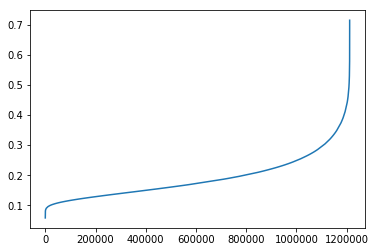

In [24]:
tf_idf_csr.data.sort()
plt.plot(tf_idf_csr.data)

In [10]:
recommender = SLIM_BPR_Cython(tf_idf_csr,recompile_cython=False,positive_threshold=0.18)

SLIM_BPR_Cython: Estimated memory required for similarity matrix of 20635 items is 1703.21 MB


In [26]:
recommender.fit(epochs=400,batch_size=20,sgd_mode='sgd',learning_rate=1e-4,topK=400)

Processed 417161 ( 100.00% ) in 1.45 seconds. BPR loss is 3.21E-06. Sample per second: 288089
SLIM_BPR_Recommender: Epoch 1 of 400. Elapsed time 0.07 min
Processed 417161 ( 100.00% ) in 1.08 seconds. BPR loss is 2.15E-05. Sample per second: 388052
SLIM_BPR_Recommender: Epoch 2 of 400. Elapsed time 0.08 min
Processed 417161 ( 100.00% ) in 0.70 seconds. BPR loss is 5.80E-05. Sample per second: 598078
SLIM_BPR_Recommender: Epoch 3 of 400. Elapsed time 0.09 min
Processed 417161 ( 100.00% ) in 1.32 seconds. BPR loss is 1.12E-04. Sample per second: 316593
SLIM_BPR_Recommender: Epoch 4 of 400. Elapsed time 0.10 min
Processed 417161 ( 100.00% ) in 0.94 seconds. BPR loss is 1.80E-04. Sample per second: 443904
SLIM_BPR_Recommender: Epoch 5 of 400. Elapsed time 0.12 min
Processed 417161 ( 100.00% ) in 1.57 seconds. BPR loss is 2.67E-04. Sample per second: 265702
SLIM_BPR_Recommender: Epoch 6 of 400. Elapsed time 0.13 min
Processed 417161 ( 100.00% ) in 1.20 seconds. BPR loss is 3.71E-04. Sample p

In [29]:
target = target.get_values()[:,0]

In [30]:
n = 500
  
# using list comprehension 
divided_target = [target[i * n:(i + 1) * n] for i in range((len(target) + n - 1) // n )]  

In [31]:
result = []
for items in target:
    partial_recomendations = recommender.recommend(items,cutoff=10)
    result.append(partial_recomendations)

In [32]:
result = np.array(result)

In [33]:
result.reshape(-1,10)

array([[ 4052,  5042, 17154, ..., 17276, 20443,  1373],
       [ 4202,   699,  1900, ...,   463, 10596,  1713],
       [ 8001,  2159, 15341, ..., 18830,  8218, 17820],
       ..., 
       [ 4986, 18287, 18956, ...,  1712,  2085, 12466],
       [ 9508,  9145,  8880, ...,  4774, 10786,  1253],
       [18150, 19152,  6492, ...,  1979, 20488, 18059]])

In [34]:
result = result.reshape(-1,10)

In [35]:
result.shape

(10000, 10)

In [36]:
i = 0
results = []
for item in result:
    recommended_items = " ".join(str(i) for i in item)
    temp = [target[i],recommended_items]
    results.append(temp)
    i += 1

In [37]:
results


[[7, '4052 5042 17154 4492 10300 11716 14765 17276 20443 1373'],
 [25, '4202 699 1900 7077 800 18567 19134 463 10596 1713'],
 [29, '8001 2159 15341 3903 15886 1944 12075 18830 8218 17820'],
 [34, '14751 15386 19540 5746 7517 10367 6285 5003 19856 11507'],
 [50, '11896 20287 13763 15354 8229 5765 17429 3074 6892 20037'],
 [52, '8456 1935 14827 8838 17247 9007 19173 18615 17709 520'],
 [60, '1898 18904 4111 18830 1944 8173 19119 15778 5261 13862'],
 [64, '5604 5726 12564 15038 8437 14869 8928 9717 10089 15905'],
 [77, '4301 17226 1290 15750 5947 2581 1698 19426 362 508'],
 [80, '18026 9670 15335 16391 12226 14683 10203 15241 5878 2212'],
 [106, '15474 6103 20263 1591 12436 10567 2873 11275 18096 20548'],
 [138, '9473 19825 18856 5149 10834 17663 6137 5882 17071 1072'],
 [143, '8491 20172 10251 868 7506 14826 18920 14732 4401 5606'],
 [149, '13980 360 4364 16471 14758 6892 18266 17239 11896 10496'],
 [169, '7157 6901 2253 19976 11268 18615 2417 6409 13043 19858'],
 [180, '6433 14322 14453

In [38]:
rec = pd.DataFrame(results)
rec.to_csv("submission.csv", index = False, header = ["playlist_id", "track_ids"])